### Compare dropout uncertainty with logvar

In [1]:
# imports
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.compat.v1 import gfile
import pdb
import pickle

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # CPU-only

sys.path.append(os.path.abspath("/home/mwu34/disentanglement_lib"))
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

from scipy.stats import spearmanr

In [2]:
def index_to_factors(index_array, factor_bases, save=False):
    """transform dataset image indices to factors."""
    factor_bases = factor_bases.astype(int)
    factors = np.zeros((len(index_array), len(factor_bases) - 1))
    for factor_idx, factor_base in enumerate(factor_bases[1:]):
        factors[:, factor_idx], index_array = np.divmod(index_array, factor_base)
    
    if save:
        save_path = os.path.join(
            os.environ.get("DISENTANGLEMENT_LIB_DATA", "."),
            "dsprites", f"{selection_criterion}.pickle"
        )
        informative_points = {
            'informative_indices': index_array,
            'informative_factors': factors
        }
        with open(save_path, 'wb') as handle:
            pickle.dump(informative_points, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(f'saved informative points to {save_path}')
    else:
        print('no save_path specified, not saving informative points')
    
    return factors

In [3]:
# retrieve the representation associated with the dataset
def retrieve_representation(dataset, module_path, num_random_points, random=False):
    with hub.eval_function_for_module(module_path) as f:
        def _gaussian_encoder(x):
            """Encodes images using trained model."""
            # Push images through the TFHub module.
            output = f(dict(images=x), signature="gaussian_encoder", as_dict=True)
            # Convert to numpy arrays and return.
            return {key: np.array(values) for key, values in output.items()}
        if random:
            select_indices = random_state.choice(len(dataset.images), num_random_points, replace=False)
            images = np.expand_dims(dataset.images[select_indices], 3)
            representation_dict = _gaussian_encoder(images)
            
        else:  # retrieve representation of the entire dataset
            num_points_per_block = 10000
            num_blocks = int(np.ceil(len(dataset.images) / num_points_per_block))
            representation_list = [0] * num_blocks
            for block in range(num_blocks):
                start_idx = num_points_per_block * block
                images = np.expand_dims(dataset.images[start_idx: start_idx + num_points_per_block], 3)
                representation_list[block] = _gaussian_encoder(images)
            representation_dict = dict()
            print(representation_list[0].keys())
            for key in representation_list[0].keys():
                representation_dict[key] = np.concatenate([block[key] for block in representation_list], axis=0)
            
        representation_dict['std'] = np.exp(representation_dict['logvar'] / 2)
        representation_dict['kl'] = (
            representation_dict['mean'] ** 2
            + representation_dict['std'] ** 2
            - representation_dict['logvar'] - 1
        ) / 2
        return representation_dict

In [4]:
# get the original dsprites dataset
from disentanglement_lib.data.ground_truth import named_data
dsprites = named_data.get_named_ground_truth_data('dsprites_full', -1)

In [31]:
dsprites.factor_bases

array([737280., 245760.,  40960.,   1024.,     32.,      1.])

In [33]:
dsprites.factor_sizes

array([ 1,  3,  6, 40, 32, 32])

In [34]:
small_factor_sizes = dsprites.factor_sizes[1:]
small_factor_bases = np.prod(small_factor_sizes) / np.cumprod(
            small_factor_sizes)

In [35]:
small_factor_bases

array([245760.,  40960.,   1024.,     32.,      1.])

In [14]:
# for a model, retrieve dropout mean and uncertainty 
model_artifact_dir = "/home/mwu34/disentanglement_lib/output_active_learning_study_v7/44/model/artifacts/"
labelled_indices = []
num_iterations = 9
num_latent = 10

dropout_mean = []
dropout_uncertainty = []

for iteration in range(10):
    file_path = os.path.join(model_artifact_dir, f"labelled_indices_iter_{iteration}.npy")
    indices = np.load(file_path)
    labelled_indices.extend(list(indices))
    if iteration > 0:
        mean_file_path = os.path.join(model_artifact_dir, f"dropout_mean_iter_{iteration}.npy")
        dropout_mean.append(np.load(mean_file_path))
        uncertainty_file_path = os.path.join(model_artifact_dir, f"dropout_uncertainty_iter_{iteration}.npy")
        dropout_uncertainty.append(np.load(uncertainty_file_path))
    
labelled_factors = index_to_factors(labelled_indices, dsprites.factor_bases, save=False)

no save_path specified, not saving informative points


In [15]:
# average uncertainty over time
average_uncertainty = np.zeros((num_iterations, num_latent))
for iteration in range(num_iterations):
    average_uncertainty[iteration, :] = np.mean(dropout_uncertainty[iteration], axis=0)
average_uncertainty

array([[0.2  , 0.306, 0.202, 0.159, 0.158, 0.007, 0.006, 0.007, 0.006,
        0.007],
       [0.209, 0.287, 0.182, 0.152, 0.152, 0.005, 0.006, 0.005, 0.005,
        0.006],
       [0.197, 0.277, 0.162, 0.15 , 0.15 , 0.005, 0.005, 0.004, 0.005,
        0.005],
       [0.189, 0.272, 0.153, 0.147, 0.148, 0.004, 0.004, 0.004, 0.004,
        0.005],
       [0.185, 0.268, 0.15 , 0.146, 0.147, 0.004, 0.004, 0.004, 0.004,
        0.004],
       [0.18 , 0.268, 0.14 , 0.146, 0.146, 0.004, 0.004, 0.004, 0.004,
        0.004],
       [0.177, 0.265, 0.138, 0.144, 0.144, 0.004, 0.004, 0.004, 0.003,
        0.004],
       [0.173, 0.262, 0.13 , 0.143, 0.143, 0.004, 0.003, 0.004, 0.003,
        0.004],
       [0.172, 0.261, 0.124, 0.142, 0.143, 0.004, 0.004, 0.004, 0.003,
        0.004]])

In [16]:
# absolute mean value over time
abs_mean = np.zeros((num_iterations, num_latent))
for iteration in range(num_iterations):
    abs_mean[iteration, :] = np.mean(np.abs(dropout_mean[iteration]), axis=0)
abs_mean

array([[0.334, 0.808, 0.218, 0.871, 0.872, 0.009, 0.006, 0.006, 0.005,
        0.006],
       [0.269, 0.781, 0.158, 0.846, 0.848, 0.006, 0.005, 0.004, 0.004,
        0.007],
       [0.23 , 0.774, 0.122, 0.834, 0.838, 0.007, 0.005, 0.003, 0.005,
        0.007],
       [0.2  , 0.769, 0.106, 0.818, 0.824, 0.005, 0.005, 0.004, 0.005,
        0.006],
       [0.186, 0.762, 0.096, 0.812, 0.817, 0.005, 0.005, 0.004, 0.005,
        0.006],
       [0.176, 0.769, 0.087, 0.809, 0.814, 0.005, 0.006, 0.004, 0.004,
        0.005],
       [0.17 , 0.761, 0.081, 0.803, 0.805, 0.005, 0.005, 0.004, 0.002,
        0.005],
       [0.159, 0.756, 0.074, 0.795, 0.799, 0.005, 0.004, 0.004, 0.002,
        0.005],
       [0.156, 0.754, 0.068, 0.793, 0.799, 0.005, 0.004, 0.003, 0.003,
        0.004]])

In [13]:
# retrieve the mean and logvar for this model
module_path = "/home/mwu34/disentanglement_lib/output_active_learning_study_v7/44/model/tfhub/"
representation_dict = retrieve_representation(dsprites, module_path, -1, False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


dict_keys(['mean', 'logvar'])


Text(0.5, 1.0, 'correlation between mean and dropout_mean')

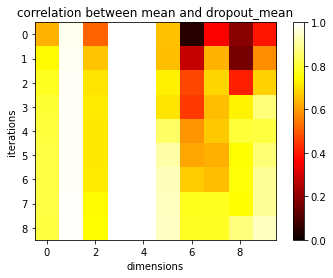

In [17]:
# compare correlation between mean and dropout_mean
mean_corr = np.zeros((num_iterations, num_latent))
for iteration in range(num_iterations):
    for latent in range(num_latent):
        results = spearmanr(representation_dict['mean'][:, latent], dropout_mean[iteration][:, latent])
        mean_corr[iteration, latent] = abs(results.correlation)
        
plt.imshow(mean_corr, cmap='hot')
plt.clim([0, 1])
plt.colorbar()
plt.xlabel('dimensions')
plt.ylabel('iterations')
plt.title('correlation between mean and dropout_mean')

In [23]:
mean_corr

array([[0.63 , 0.981, 0.514, 0.998, 0.998, 0.654, 0.044, 0.361, 0.191,
        0.397],
       [0.74 , 0.987, 0.657, 0.999, 0.999, 0.652, 0.28 , 0.633, 0.163,
        0.575],
       [0.78 , 0.989, 0.705, 0.999, 0.999, 0.725, 0.472, 0.686, 0.411,
        0.678],
       [0.798, 0.99 , 0.716, 0.999, 0.999, 0.705, 0.452, 0.649, 0.73 ,
        0.865],
       [0.809, 0.991, 0.711, 0.999, 0.999, 0.847, 0.587, 0.666, 0.801,
        0.81 ],
       [0.813, 0.992, 0.713, 0.999, 0.999, 0.913, 0.614, 0.626, 0.742,
        0.862],
       [0.814, 0.992, 0.716, 0.999, 0.999, 0.931, 0.668, 0.649, 0.755,
        0.897],
       [0.814, 0.992, 0.74 , 0.999, 0.999, 0.937, 0.775, 0.778, 0.748,
        0.896],
       [0.809, 0.992, 0.744, 0.999, 0.999, 0.939, 0.784, 0.784, 0.87 ,
        0.935]])

Text(0.5, 1.0, 'correlation between logvar and dropout_uncertainty')

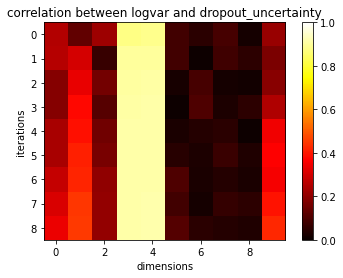

In [18]:
# compare correlation between logvar and dropout_uncertainty
uncertainty_corr = np.zeros((num_iterations, num_latent))
for iteration in range(num_iterations):
    for latent in range(num_latent):
        results = spearmanr(representation_dict['logvar'][:, latent], dropout_uncertainty[iteration][:, latent])
        uncertainty_corr[iteration, latent] = abs(results.correlation)
        
plt.imshow(uncertainty_corr, cmap='hot')
plt.clim([0, 1])
plt.colorbar()
plt.xlabel('dimensions')
plt.ylabel('iterations')
plt.title('correlation between logvar and dropout_uncertainty')

In [19]:
uncertainty_corr

array([[0.25 , 0.133, 0.22 , 0.879, 0.886, 0.085, 0.05 , 0.09 , 0.019,
        0.213],
       [0.257, 0.303, 0.069, 0.899, 0.902, 0.084, 0.004, 0.079, 0.053,
        0.17 ],
       [0.184, 0.335, 0.158, 0.905, 0.907, 0.023, 0.091, 0.018, 0.013,
        0.188],
       [0.186, 0.376, 0.117, 0.91 , 0.91 , 0.007, 0.104, 0.03 , 0.054,
        0.25 ],
       [0.236, 0.387, 0.153, 0.91 , 0.911, 0.027, 0.042, 0.049, 0.008,
        0.344],
       [0.236, 0.412, 0.165, 0.911, 0.913, 0.044, 0.028, 0.073, 0.033,
        0.366],
       [0.28 , 0.418, 0.201, 0.911, 0.913, 0.102, 0.023, 0.043, 0.027,
        0.352],
       [0.309, 0.447, 0.205, 0.912, 0.915, 0.083, 0.017, 0.063, 0.053,
        0.393],
       [0.338, 0.451, 0.207, 0.912, 0.915, 0.111, 0.05 , 0.039, 0.033,
        0.423]])

In [20]:
all_factors = index_to_factors(np.arange(len(dsprites.images)), dsprites.factor_bases, save=False)

no save_path specified, not saving informative points


Text(0.5, 1.0, 'correlation between ground_truth and dropout_mean')

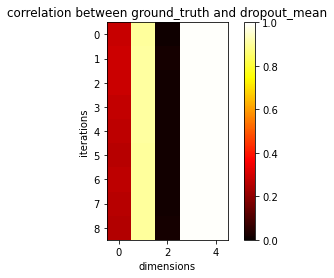

In [21]:
# compare dropout mean to ground truth factor values
num_gt_factors = 5
ground_truth_mean_corr = np.zeros((num_iterations, num_gt_factors))
for iteration in range(num_iterations):
    for latent in range(num_gt_factors):
        results = spearmanr(dropout_mean[iteration][:, latent], all_factors[:, latent])
        ground_truth_mean_corr[iteration, latent] = abs(results.correlation)
        
plt.imshow(ground_truth_mean_corr, cmap='hot')
plt.clim([0, 1])
plt.colorbar()
plt.xlabel('dimensions')
plt.ylabel('iterations')
plt.title('correlation between ground_truth and dropout_mean')

In [22]:
ground_truth_mean_corr

array([[0.283, 0.899, 0.01 , 0.995, 0.995],
       [0.29 , 0.903, 0.016, 0.996, 0.996],
       [0.287, 0.903, 0.015, 0.996, 0.996],
       [0.275, 0.903, 0.015, 0.996, 0.996],
       [0.269, 0.903, 0.015, 0.996, 0.996],
       [0.26 , 0.902, 0.014, 0.996, 0.996],
       [0.266, 0.902, 0.014, 0.996, 0.996],
       [0.259, 0.901, 0.015, 0.996, 0.996],
       [0.252, 0.901, 0.017, 0.996, 0.996]])